In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7
VAL_FRACTION = 0.25
MIN_COMMENT_LEN = 25
TOP_N = 5
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# MORE ABOUT MODEL NAMES: 
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization

## GET DATA

In [5]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '285967',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/_al0scMG_pQfGVM31Scf1Q__thumb/img/OMVAMJX95HNO-vSRdk-kGjAzzBY=/fit-in/200x150/filters:strip_icc()/pic6107853.jpg',
  'name': 'Ankh: Gods of Egypt',
  'yearpublished': '2021'},
 {'id': '337627',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/hItZjdDTNuaCZ7fEztwcUQ__thumb/img/Ov6eWR87PZ2O1XYQtXMO6KvfzOg=/fit-in/200x150/filters:strip_icc()/pic6153324.jpg',
  'name': 'Voidfall',
  'yearpublished': '2022'}]

In [6]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

missing csv file, getting new data using API...
page number = 10 (max: 100, len: 23)
page number = 20 (max: 100, len: 16)
page number = 30 (max: 100, len: 12)
page number = 40 (max: 100, len: 9)
page number = 50 (max: 100, len: 5)
page number = 60 (max: 100, len: 4)
page number = 70 (max: 100, len: 4)
page number = 80 (max: 100, len: 3)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 100, len: 1)
comments_df shape: (92436, 4)


,id,username,rating,value
0,285967,07734,N/A,GG - NOT Paid
1,285967,8janek8,N/A,"$(revolut-253,53USD), 2021 05, Eternal Pledge,..."
2,285967,abraxasdf,10,Should not let you rate a game before it even ...
3,285967,AcquisitionDisorder,N/A,Kickstarter all in edition
4,285967,aeonphreak,N/A,paid and awaiting via kickstarter
...,...,...,...,...
92431,167791,z_zadar,9,Some games are so much fun. Others can be a li...
92432,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
92433,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
92434,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [7]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [8]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 15211 for 'remove_short_comments' - min len: 25 - method: unrated


In [9]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [10]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

9         14206
10        14111
8         12581
7          6953
N/A        6253
          ...  
9.975         1
9.9149        1
4.25          1
4.24          1
6.65          1
Name: rating, Length: 531, dtype: int64

In [11]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(70972, 5)

In [12]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(6253, 5)

## CREATE TRAINING AND VALIDATION DATA

In [13]:
# use rated comments (reviews) to train the model

In [14]:
rated_comments = rated_comments.sample(frac=1)

In [15]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [16]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'Only five plays in, future plays will determine where this game settles. I am learning more about this game each time I play it. It might be a Terra Mystica killer for me.'

In [17]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


"It is possible that I don't understand this game very well yet, but it is not an easy one to play nor did I find it very enjoyable  2021-05-03   digital"

## COMPOSE MODEL

In [19]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [20]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
35/35 - 4s - loss: 0.6142 - accuracy: 0.7143 - val_loss: 0.5372 - val_accuracy: 0.8335
Epoch 2/100
35/35 - 2s - loss: 0.5033 - accuracy: 0.8420 - val_loss: 0.4686 - val_accuracy: 0.8452
Epoch 3/100
35/35 - 2s - loss: 0.4276 - accuracy: 0.8465 - val_loss: 0.4056 - val_accuracy: 0.8477
Epoch 4/100
35/35 - 2s - loss: 0.3610 - accuracy: 0.8579 - val_loss: 0.3617 - val_accuracy: 0.8598
Epoch 5/100
35/35 - 2s - loss: 0.3127 - accuracy: 0.8787 - val_loss: 0.3383 - val_accuracy: 0.8685
Epoch 6/100
35/35 - 2s - loss: 0.2780 - accuracy: 0.8907 - val_loss: 0.3263 - val_accuracy: 0.8705
Epoch 7/100
35/35 - 2s - loss: 0.2506 - accuracy: 0.9029 - val_loss: 0.3222 - val_accuracy: 0.8721
Epoch 8/100
35/35 - 2s - loss: 0.2268 - accuracy: 0.9144 - val_loss: 0.3265 - val_accuracy: 0.8720
Epoch 9/100
35/35 - 2s - loss: 0.2060 - accuracy: 0.9224 - val_loss: 0.3303 - val_accuracy: 0.8697
Epoch 10/100
35/35 - 2s - loss: 0.1869 - accuracy: 0.9310 - val_loss: 0.3397 - val_accuracy: 0.8685
Epoch 11/

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000023490DC3B80>,
             param_grid={})

In [21]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [22]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [24]:
epochs = range(1, len(acc) + 1) 

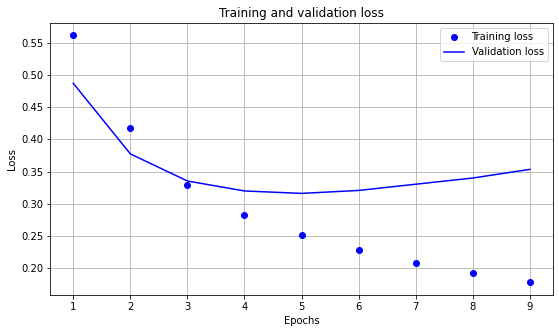

In [25]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

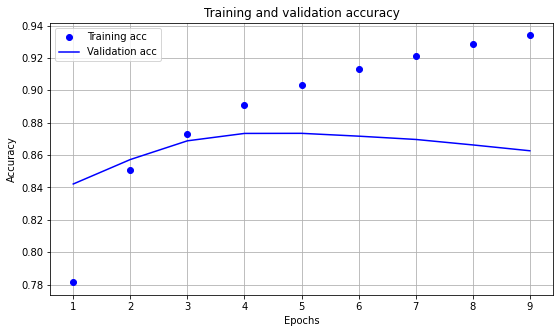

In [26]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [27]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"Only five plays in, future plays will determine where this game settles. I am learning more about this game each time I play it. It might be a Terra Mystica killer for me."
score: 1.000000
actual: 1

input:
"It is possible that I don't understand this game very well yet, but it is not an easy one to play nor did I find it very enjoyable  2021-05-03   digital"
score: 0.000000
actual: 0

input:
"After 25 games - this is keeping better and better :O After playing all possible scenarios that have come to us and following through the full storyline - it didn't keep as brilliant as it was in the midpoint of the game, but still very good.  Crazy good package of Dungeon crawling!"
score: 1.000000
actual: 1

input:
"German KS Edition"
score: 1.000000
actual: 1

input:
"Just... Incredibile... 10 stars!"
score: 1.000000
actual: 1

input:
"- The rulebook is quite clear (there are only a few open questions left, with official answers on BGG), but important information is a bit buried in it 

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [28]:
## APPLY MODEL ON NON-RATED COMMENTS

In [29]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

7/7 - 0s
input:
"Nice cooperative Marvel champion games, worth to get one copy for 1-4 players"
score: 1.000000

input:
"Wife got this for me for Valentine's day 2021"
score: 1.000000

input:
"Played a friend's copy and really enjoyed it. It's difficult and has a large learning curve but we felt we got close enough that we might win next time."
score: 1.000000

input:
"I want the release of the characters and ?? whatever few things blend with the other games in this series (Gloomhaven: Jaws of the Lion, Frosthaven, anything made later...), from each game to use in each without having to buy them all (especially this overbloated one with the most difficult setup/takedown and rules...) Please Please Please."
score: 1.000000

input:
"Base Game - Return to Night at the Zealots  Dunwich Legacy - Miskatonic Museum, Essex County Express, Blood on the Alter, Undimensioned and Unseen, Where Doom Awaits, Lost in Time and Space, Return to Dunwich Legacy  Path to Carcossa  Carnevale of Horrors Cur

## REGRESSOR

In [30]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000002380ECF25B0>,
             param_grid={})

In [31]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [32]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [33]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [34]:
epochs = range(1, len(mean_squared_error) + 1) 

In [35]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.55


In [36]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 0.99


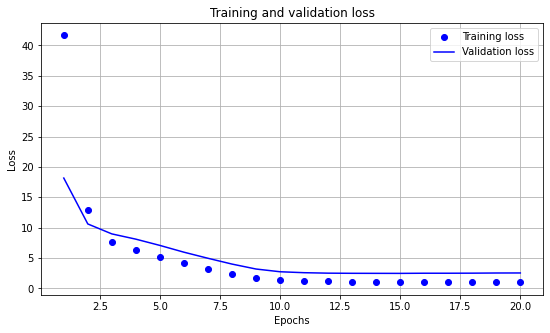

In [37]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

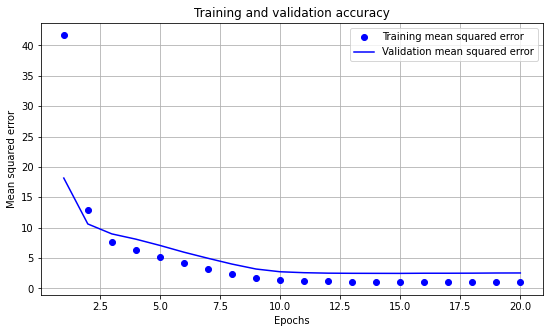

In [38]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [39]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"Only five plays in, future plays will determine where this game settles. I am learning more about this game each time I play it. It might be a Terra Mystica killer for me."
score: 7.94
actual: 8.00 

input: 
"It is possible that I don't understand this game very well yet, but it is not an easy one to play nor did I find it very enjoyable  2021-05-03   digital"
score: 7.24
actual: 6.00 

input: 
"After 25 games - this is keeping better and better :O After playing all possible scenarios that have come to us and following through the full storyline - it didn't keep as brilliant as it was in the midpoint of the game, but still very good.  Crazy good package of Dungeon crawling!"
score: 7.94
actual: 8.00 

input: 
"German KS Edition"
score: 8.28
actual: 9.00 

input: 
"Just... Incredibile... 10 stars!"
score: 9.81
actual: 10.00 

input: 
"- The rulebook is quite clear (there are only a few open questions left, with official answers on BGG), but important information is a bit buried

## COMPARE CLASSIFIER VS REGRESSOR

In [40]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"I love games where you lvl up! This looks soo amazing.  Prob my #1 wanted game!"
    reg score: 10.05
    clf score: 1

"1-4 Players Worker placement Deck building"
    reg score: 8.64
    clf score: 1

"Picked up online: Boardgamebliss."
    reg score: 7.48
    clf score: 1

"Insert BeastProductions + Coins + Gamefit & Laserland Whinebottles"
    reg score: 8.43
    clf score: 1

"Looks interesting but I will wait. I'm not paying scalper prices for it"
    reg score: 6.89
    clf score: 0

"Includes TM: Prelude expansion in base game."
    reg score: 8.31
    clf score: 1

"Insert Here insert Premium sleeves"
    reg score: 10.21
    clf score: 1

"Why „want to play”? It was on Spiel2019 “must play” list."
    reg score: 8.52
    clf score: 0

"VG condition. Played three times."
    reg score: 6.61
    clf score: 0

"(Kickstarted, premium pledge) + exp Invasores de Tierras Lejanas + exp Vientos de Guerra y Paz + exp Encuentros + exp El Auge de Fenris"
    reg score: 7.98
    clf scor

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [41]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 162886 |          8.37 |           3657 |
| 167355 |          8.41 |           1960 |
| 167791 |          8.21 |           8457 |
| 169786 |          8.10 |           7475 |
| 174430 |          8.52 |           6482 |


In [42]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [43]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 162886 |          8.12 |            323 |
| 167355 |          8.03 |            215 |
| 167791 |          8.11 |            450 |
| 169786 |          8.06 |            602 |
| 174430 |          8.07 |            567 |


In [44]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [45]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/_al0scM...","<a href=""https://boardgamegeek.com/boardgame/2...",7.311441,7.403551,7.344800,1,2021
1,"<img src=""https://cf.geekdo-images.com/hItZjdD...","<a href=""https://boardgamegeek.com/boardgame/3...",10.000000,7.319732,7.587759,2,2022
2,"<img src=""https://cf.geekdo-images.com/gc5ZZ_X...","<a href=""https://boardgamegeek.com/boardgame/3...",3.500000,6.598234,4.119647,3,2022
3,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.759297,7.804628,7.762441,4,2020
4,"<img src=""https://cf.geekdo-images.com/FCz9Iu2...","<a href=""https://boardgamegeek.com/boardgame/3...",5.000000,7.951954,6.967969,5,2022


In [46]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [47]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Ankh: Gods of Egypt,7.311441,7.403551,7.344800,1,2021
2,,Voidfall,10.000000,7.319732,7.587759,2,2022
3,,Divinus,3.500000,6.598234,4.119647,3,2022
4,,Lost Ruins of Arnak,7.759297,7.804628,7.762441,4,2020
5,,Earthborne Rangers,5.000000,7.951954,6.967969,5,2022


In [48]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Voidfall,10.000000,7.319732,7.587759,2,2022
2,,World of Warcraft: Wrath of the Lich King,9.333333,8.047443,9.011861,13,2021
3,,Architects of the West Kingdom: Works of Wonder,9.100000,8.298414,8.355671,21,2022
4,,Chronicles of Drunagor: Age of Darkness,8.890459,8.102375,8.795126,29,2021
5,,Summoner Wars (Second Edition),8.783731,7.037440,8.556940,45,2021


In [49]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,World of Warcraft: Wrath of the Lich King,9.333333,8.047443,9.011861,13,2021
2,,Chronicles of Drunagor: Age of Darkness,8.890459,8.102375,8.795126,29,2021
3,,Brass: Birmingham,8.674275,8.148285,8.627755,30,2018
4,,Summoner Wars (Second Edition),8.783731,7.037440,8.556940,45,2021
5,,Gloomhaven: Jaws of the Lion,8.558327,7.990787,8.504222,28,2020


In [50]:
# model.save('saved_model\my_model')

In [51]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [52]:
# some examples on "long" comments vs short comments

In [53]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [54]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"Very Good- all bags and components in box. Tokens all punched, and all components sorted into small plastic boxes. Boxes and bags will come with game. Feel free to message me with any additional inquiries."
score: 6.90

"This looks neat.  I was really excited about it.  However, as I read the rules, I can’t help but think about how tedious asymmetry is in games,  and the more asymmetric, the more tedious.  The art is mediocre.  The game looks like it will be good."
score: 7.04

"Kickstarter edition with extra player boards, apprentices, buildings promos and tax stand frame.  NIS"
score: 7.22

"P: 1-4, T: 90-150 min Co-op Legacy/campaign style character progression. Dungeon crawl scenarios w/ streamlined card play combat system. A faithful conversion of an MMORPG to tabletop form; be prepared to sink a lot of time into this one. Headed for the "Pedestal of Longing""
score: 7.27

"More complex than Catan (2.93). Very highly rated game (rank 18 overall). I think it looks very fun, but mi

## RANDOM FOREST - TEST

In [55]:
# no support for Windows at the moment - waiting for it to test